In [136]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #to supress import warnings

# Preprocessing Data

In [2]:
#COLUMNS = ['station','date','feature', 'value', 'measurement','quality', 'source', 'hour']
COLUMNS_test = ['station','date']

In [3]:
# load data
df_train = pd.read_csv('../data/export_features_loc_MAX.csv', index_col=0, low_memory=False)

In [4]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y%m%d', errors='ignore')
df_train.head()

,station,date,TMIN,lat,long,elev
0,AE000041196,2014-01-01,128,25.333,55.517,34.0
1,AE000041196,2014-01-02,145,25.333,55.517,34.0
2,AE000041196,2014-01-03,140,25.333,55.517,34.0
3,AE000041196,2014-01-06,162,25.333,55.517,34.0
4,AE000041196,2014-01-09,115,25.333,55.517,34.0


In [5]:
# Do you want to use past days as predictor?
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
#get year and date as features
df = df_train
df = df_train_yd.drop(columns='date')
df['year'] = df_train['date'].map(lambda x: x.year)
df['day'] = df_train['date'].map(lambda x: x.timetuple().tm_yday)
df.head(20)

,station,date,TMIN,lat,long,elev,year,day
0,AE000041196,2014-01-01,128,25.333,55.517,34.0,2014,1
1,AE000041196,2014-01-02,145,25.333,55.517,34.0,2014,2
2,AE000041196,2014-01-03,140,25.333,55.517,34.0,2014,3
3,AE000041196,2014-01-06,162,25.333,55.517,34.0,2014,6
4,AE000041196,2014-01-09,115,25.333,55.517,34.0,2014,9
5,AE000041196,2014-01-11,159,25.333,55.517,34.0,2014,11
6,AE000041196,2014-01-13,145,25.333,55.517,34.0,2014,13
7,AE000041196,2014-01-15,137,25.333,55.517,34.0,2014,15
8,AE000041196,2014-01-17,118,25.333,55.517,34.0,2014,17
9,AE000041196,2014-01-18,117,25.333,55.517,34.0,2014,18


In [9]:
# export data to reduce preproccesing duration
#df_train_yd.to_csv('../data/tmp/export_LSMT_MAX_yd.csv')

### Getting the data ready for LMST

In [34]:
# importing the preprocessed data for a quicker start
df = pd.read_csv('../data/tmp/export_LSMT_MAX_yd.csv', index_col=0, low_memory=False)

In [84]:
# pick random stations for test and training
seed = 93598357
np.random.seed(seed)
stations = df.station.unique()
np.random.shuffle(stations)
stations_shuffled = stations
stations_train = stations_shuffled[:2000]
stations_holdout = stations_shuffled[2000:4000]

df_train_test = df[df['station'].isin(stations_train)]
df_train_test.head()

,station,TMIN,lat,long,elev,year,day
4039,AG000060590,30,30.5667,2.8667,397.0,2014,1
4040,AG000060590,31,30.5667,2.8667,397.0,2014,2
4041,AG000060590,36,30.5667,2.8667,397.0,2014,3
4042,AG000060590,60,30.5667,2.8667,397.0,2014,4
4043,AG000060590,50,30.5667,2.8667,397.0,2014,5


In [88]:
#divide test and training to test effective of model to different timeframe (start of 2017)
training_years = [2014,2015,2016]
testing_days = range(80)

df_train = df_train_test[df_train_test['year'].isin(training_years)]
df_test = df_train_test[df_train_test['day'].isin(testing_days)]
print(df_train.shape,df_test.shape)

(1792641, 7) (514252, 7)


In [89]:
#seperate target from features
df_X_train_raw = df_train.drop(columns='TMIN')
df_X_test_raw = df_test.drop(columns='TMIN')
sy_train = df_train['TMIN'].values
sy_test = df_test['TMIN'].values
y_train_raw = sy_train.reshape(-1,1)
y_test_raw = sy_test.reshape(-1,1)

In [90]:
df_X_train_raw.shape

(1792641, 6)

In [91]:
# int encode stations
#LB = LabelBinarizer()
#df_X['station'] = LB.fit_transform(df_X[['station']])
df_X_train_red = df_X_train_raw.drop(columns='station')
df_X_test_red = df_X_test_raw.drop(columns='station')

In [92]:
#X_dict = df_X.to_dict('records')
#vec = DictVectorizer()
#X = vec.fit_transform(X_dict).toarray()
#X_dummies = pd.get_dummies(df_X)
#X = X_dummies.to_dict('records')

In [131]:
# normalize features
X_train_raw = df_X_train_red.values
X_test_raw = df_X_test_red.values
X_train_raw = X_train_raw.astype('float32')
X_test_raw = X_test_raw.astype('float32')
y_train_raw = y_train_raw.astype('float32')
y_test_raw = y_test_raw.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))                             
train_X = scaler.fit_transform(X_train_raw)
test_X = scaler.fit_transform(X_test_raw)
train_y = scaler.fit_transform(y_train_raw)
test_y = scaler.fit_transform(y_test_raw)

In [132]:
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

(1792641, 5) (1792641, 1) (514252, 5) (514252, 1)


In [133]:
# specify the number of lag days
n_days = 0
n_features = 1
# frame as supervised learning
#reframed = scaled #series_to_supervised(scaled, n_days, 1)

In [134]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((1792641,1,5))
test_X = test_X.reshape((514252,1,5))

# LSTMs

Train on 1792641 samples, validate on 514252 samples
Epoch 1/20
 - 50s - loss: 0.0273 - val_loss: 0.1103
Epoch 2/20
 - 46s - loss: 0.0199 - val_loss: 0.0960
Epoch 3/20
 - 46s - loss: 0.0195 - val_loss: 0.0828
Epoch 4/20
 - 37s - loss: 0.0194 - val_loss: 0.0742
Epoch 5/20
 - 36s - loss: 0.0195 - val_loss: 0.0689
Epoch 6/20
 - 37s - loss: 0.0195 - val_loss: 0.0655
Epoch 7/20
 - 37s - loss: 0.0196 - val_loss: 0.0631
Epoch 8/20
 - 37s - loss: 0.0196 - val_loss: 0.0612
Epoch 9/20
 - 41s - loss: 0.0196 - val_loss: 0.0597
Epoch 10/20
 - 47s - loss: 0.0196 - val_loss: 0.0585
Epoch 11/20
 - 44s - loss: 0.0197 - val_loss: 0.0575
Epoch 12/20
 - 47s - loss: 0.0197 - val_loss: 0.0567
Epoch 13/20
 - 49s - loss: 0.0197 - val_loss: 0.0560
Epoch 14/20
 - 50s - loss: 0.0197 - val_loss: 0.0555
Epoch 15/20
 - 49s - loss: 0.0198 - val_loss: 0.0550
Epoch 16/20
 - 43s - loss: 0.0197 - val_loss: 0.0546
Epoch 17/20
 - 50s - loss: 0.0197 - val_loss: 0.0542
Epoch 18/20
 - 49s - loss: 0.0196 - val_loss: 0.0538
Ep

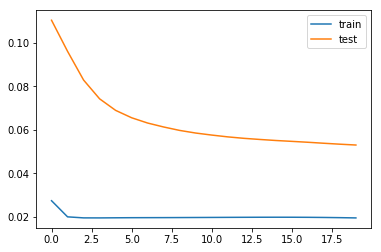

In [128]:
# design network
learning_rate = 0.2
epochs = 20
decay_rate = learning_rate / epochs

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dense(10))
model.add(Dense(1))
adam = Adam(lr = learning_rate, decay=decay_rate)
model.compile(loss='mae', optimizer=adam)
# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=200, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [129]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 162.513


In [ ]:
# grid search for optimal parameters
def create_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1],train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
    return model

np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 20, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(train_X, train_y).score(X_test, y_test)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [121]:
# grid search for optimal parameters
def create_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1],train_X.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
    return model

np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = 
epochs = 
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(train_X, train_y).score(X_test, y_test)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

ValueError: Error when checking : expected lstm_15_input to have 3 dimensions, but got array with shape (514252, 5)

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# import kaggle scoring data
df_score = pd.read_csv('../data/2018_test.csv', header=None, names=COLUMNS_test, low_memory=False)